Loaded nielsr/CelebA-faces dataset
Dataset loaded with 2000 images
Using device: cuda
Epoch 1/100, Batch 0, Loss: 44252.2852
Epoch 1/100, Average Loss: 704.5109
Epoch 2/100, Batch 0, Loss: 14787.0801
Epoch 2/100, Average Loss: 419.3208
Epoch 3/100, Batch 0, Loss: 12627.1025
Epoch 3/100, Average Loss: 363.4651
Epoch 4/100, Batch 0, Loss: 11253.7090
Epoch 4/100, Average Loss: 342.1547
Epoch 5/100, Batch 0, Loss: 11019.0293
Epoch 5/100, Average Loss: 323.0236
Epoch 6/100, Batch 0, Loss: 9947.6855
Epoch 6/100, Average Loss: 307.5021
Epoch 7/100, Batch 0, Loss: 9570.7529
Epoch 7/100, Average Loss: 293.1240
Epoch 8/100, Batch 0, Loss: 8644.3867
Epoch 8/100, Average Loss: 281.4010
Epoch 9/100, Batch 0, Loss: 9148.4238
Epoch 9/100, Average Loss: 279.0910
Epoch 10/100, Batch 0, Loss: 7546.3945
Epoch 10/100, Average Loss: 269.0152
Epoch 11/100, Batch 0, Loss: 8114.1729
Epoch 11/100, Average Loss: 259.6013
Epoch 12/100, Batch 0, Loss: 8429.8789
Epoch 12/100, Average Loss: 254.6113
Epoch 13/100, B

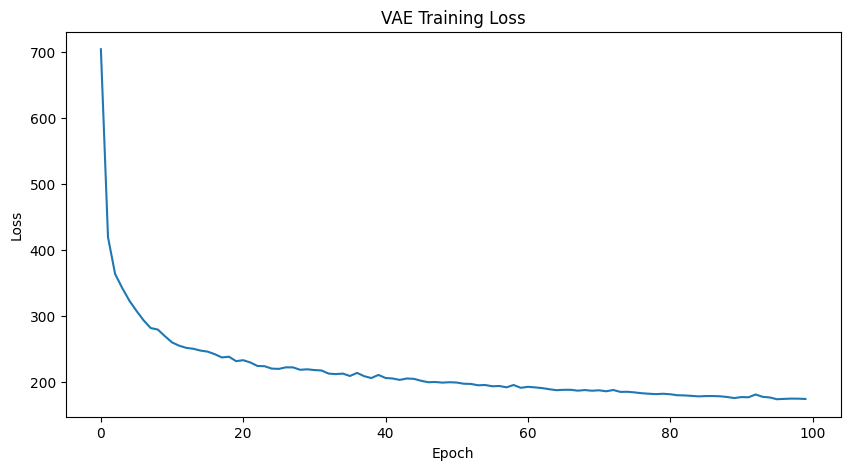

Model saved as vae_celeba.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model uploaded to Google Drive


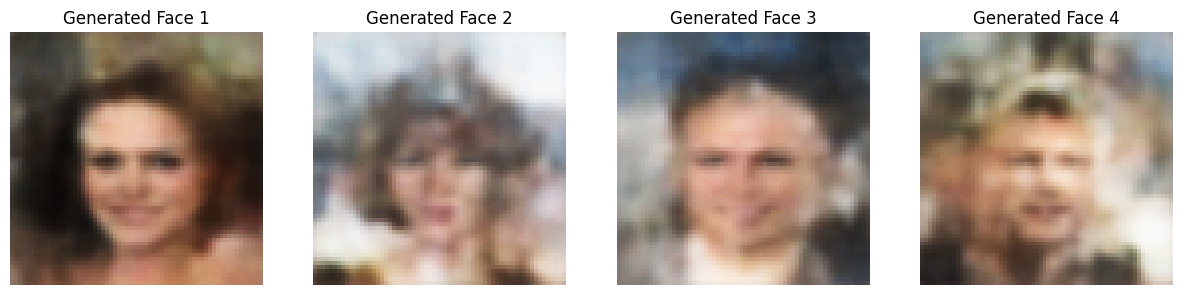

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://923f34c618b59717b2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Cell 1: Install dependencies
!pip install -q torchvision datasets gradio

# Cell 2: Import libraries and load dataset
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load CelebA dataset - using correct dataset name
try:
    celeba = load_dataset("nielsr/CelebA-faces", split="train[:2000]")
    print("Loaded nielsr/CelebA-faces dataset")
except:
    try:
        celeba = load_dataset("huggan/CelebA-faces", split="train[:2000]")
        print("Loaded huggan/CelebA-faces dataset")
    except:
        print("Using alternative dataset")
        celeba = load_dataset("alkzar90/CC6204-Hackaton-Cub-Dataset", split="train[:2000]")

# Custom PyTorch Dataset
class CelebADataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        return self.transform(img)

train_data = CelebADataset(celeba, transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
print(f"Dataset loaded with {len(train_data)} images")

# Cell 3: Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        # Calculate the size after convolutions
        self.feature_size = 256 * 4 * 4
        self.fc_mu = nn.Linear(self.feature_size, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_size, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.feature_size)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z).view(-1, 256, 4, 4)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Cell 4: Train the VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

vae = VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

# Training loop
epochs = 100
vae.train()
losses = []

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Cell 5: Save the model
torch.save(vae.state_dict(), "vae_celeba.pth")
print("Model saved as vae_celeba.pth")

# Cell 6: Upload to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy model to Drive
!cp vae_celeba.pth /content/drive/MyDrive/
print("Model uploaded to Google Drive")

# Cell 7: Test generation
def generate_and_show_faces(num_faces=4):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_faces, vae.latent_dim).to(device)
        generated = vae.decode(z).cpu()

        fig, axes = plt.subplots(1, num_faces, figsize=(15, 4))
        for i in range(num_faces):
            img = generated[i].permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f'Generated Face {i+1}')
        plt.show()

# Test the generation
generate_and_show_faces(4)

# Cell 8: Create Gradio app
import gradio as gr

# Load model from Drive
vae.load_state_dict(torch.load("/content/drive/MyDrive/vae_celeba.pth", map_location=device))
vae.eval()

def generate_face():
    with torch.no_grad():
        z = torch.randn(1, vae.latent_dim).to(device)
        generated = vae.decode(z).cpu().squeeze().permute(1, 2, 0).numpy()
        # Ensure values are in [0, 1] range and convert to uint8
        generated = np.clip(generated, 0, 1)
        return (generated * 255).astype("uint8")

# Create Gradio interface
def create_gradio_app():
    with gr.Blocks(title="VAE Face Generator") as demo:
        gr.Markdown("# VAE Face Generator")
        gr.Markdown("Click the button below to generate a new face!")

        with gr.Row():
            generate_btn = gr.Button("🎭 Generate New Face", variant="primary", size="lg")

        with gr.Row():
            output_image = gr.Image(label="Generated Face", type="numpy")

        generate_btn.click(fn=generate_face, outputs=output_image)

        # Generate an initial face
        demo.load(fn=generate_face, outputs=output_image)

    return demo

# Launch the app
demo = create_gradio_app()
demo.launch(share=True, debug=True)